# LSTM NN to forecast Dst index with OMNIweb data

by Jari Peeperkorn


THIS IS A VERSION THAT ONLY USES DST AS INPUT!


        NOTE TO JARI: HERE IT LOOKS LIKE BATCH SIZE = SEQUENCE LENGTH
        
        ALSO CHECK HOW BACKPROPAGATING WORKS: I THINK IT BACKPROPAGATES AFTER EVERY BATCH BUT NOT SURE

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# Settings of the neural network

Choose the amount of hours in advance you want to forecast, this has to be changed to multiple options later

In [31]:
Forecasting_hour = 3

Choose the number of epochs and the learning rate

In [32]:
num_epochs = 1000

learning_rate = 0.001

Choose how many percentage of data should be training data, cross validation (for finetuning hyperparameters), the rest will be test data

In [33]:
Partition_training = 0.6 # 60% data = training set
Partition_Cross_Validation = 0.2 # 20% data = cross validation set

Choose the number of LSTM layers, hidden layer size

In [34]:
num_layers = 1
hidden_layer_size = 25

Define batch size

In [35]:
batch_size = 64

# Model LSTM Neural Network

    initialisation Linear layer
linear(size of each input sample, size of each output sample, bias=True/False)

    shape input linear layer
$(N, *, \text{size of each input sample})$ where * means any number of additional dimensions, N is the batch size

    shape output linear layer
$(N, *, \text{size of each output sample})$ where all but the last dimension are the same shape as the input.

    initialising the LSTM layer
lstm(Number of expected features input, number of features in hidden state, number of recurrent layers (default 1), bias=True/False, ...) 

    Shape of inputs lstm (input, (h_0, c_0))
input shape (seq_len, batch, input_size): tensor containing the features of the input sequence.

h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. If the RNN is bidirectional, num_directions should be 2, else it should be 1.

c_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial cell state for each element in the batch.

If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.

    Shape of outputs lstm (output, (h_n, c_n))
output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features (h_t) from the last layer of the LSTM, for each t.

h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.

c_n (num_layers * num_directions, batch, hidden_size): tensor containing the cell state for t = seq_len



NOTE TO JARI: check dropout

In [36]:
class lstm(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, batch_size, dropout):
        super(lstm, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, dropout=self.dropout)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        
    def forward(self, x, hidden):
        x = x.reshape(self.batch_size, -1, self.input_dim)
        out, hidden = self.lstm(x)
        out.reshape(-1, self.hidden_dim)
        out = self.output(out)
        return(out, hidden)

# Data processing

Name of the text file we are using. This is hourly data from OMNIWEB from 2011-2013.

Columns are

1 YEAR                                
2 DOY                                   
 3 Hour                                  
 4 Scalar B, nT                        
 5 BZ, nT (GSE)                        
 6 SW Proton Density, N/cm^3           
 7 SW Plasma Speed, km/s               
 8 Dst-index, nT                         

In [37]:
text_file_data = "20112013data.txt"

Choose data type

In [38]:
dtype = torch.float

Read in with pandas

In [39]:
datapanda = pd.read_csv(text_file_data,delim_whitespace=True,header=None)

Quantify total number of parameters. This assumes that the first 3 columns are timestamps. This number is useful if you don't want to use all the columns. 

In [40]:
NrParam = datapanda.values[0].shape[0] - 3

Get all the inputparameters, without timestamps but including Dst index.

In [41]:
Parameters = datapanda.loc[:,3:(2+NrParam)].values

If you want to use all the columns as input (including Dst), comment first code block. If you want to use specifc data columns comment second block.

In [42]:
#Indices_inputdata = [0,7,9,10,14] 
#inputdata = Parameters[:,Indices_inputdata] 

In [43]:
inputdata = Parameters

Get the Dst index

In [44]:
Dst = datapanda.loc[:,2+NrParam].values
print(Dst)

[-11 -11  -9 ...  -1  -2  -3]


Center the Dst. We first give a fucntion that centers data by subtracting by its mean and normalizing by dividing by its standard deviation.

NOTE TO JARI: DO WE HAVE TO CENTER THIS DATA?

In [45]:
def centering_data(data):
    meandata = np.mean(data)
    stddevdata = np.std(data)
    centered = (data-meandata)/stddevdata
    return centered

Dst = centering_data(Dst)
print(Dst)

[0.00162595 0.00162595 0.11496773 ... 0.56833488 0.51166398 0.45499309]


Obtain the total amount of time-ticks (how many hours of data)

In [46]:
Totaltimeticks = datapanda.values.shape[0]

Partition the amount of time accordingly, and obtain split, centered data sets

In [47]:
partCV = int(Partition_training * Totaltimeticks)
partTest = int(Partition_Cross_Validation * Totaltimeticks) + partCV

DsttrainNumpy = Dst[0:partCV]
DstCVNumpy = Dst[partCV:partTest]
DsttestNumpy = Dst[partTest:-1]

In [48]:
#Convert these centered inputdata and Dst output to pytorch tensors
Dsttrain = torch.Tensor(DsttrainNumpy).type(torch.Tensor)
DstCV = torch.from_numpy(DstCVNumpy).type(torch.Tensor)
Dsttest = torch.from_numpy(DsttestNumpy).type(torch.Tensor)

print(Dsttrain)

tensor([ 0.0016,  0.0016,  0.1150,  ..., -0.1117, -0.0550,  0.0583])


We unsqueeze because I think it has to look this shape from what I found online. The first forecasting_hours are deleted from the y array.

In [49]:
values = Dsttrain

x = values[:-1].unsqueeze(1)
y = values[Forecasting_hour:].unsqueeze(1)

print(x)
print(y)

tensor([[ 0.0016],
        [ 0.0016],
        [ 0.1150],
        ...,
        [-0.2251],
        [-0.1117],
        [-0.0550]])
tensor([[ 0.3417],
        [ 0.4550],
        [ 0.3983],
        ...,
        [-0.1117],
        [-0.0550],
        [ 0.0583]])


The chunks is the amount of data batches we can make of length batch_size (sequence length here as well). We are going to "split" the data into batches.

In [50]:
chunks = len(x) // batch_size

print(chunks)

246


times is the amount of data we are going to forecast, used for plotting later

we delete the extra data in x that is remainder after dividing into batches

In [51]:
times = torch.arange(1, chunks * batch_size + 1)
x = x[:chunks * batch_size]
print(times)

tensor([    1,     2,     3,  ..., 15742, 15743, 15744])


Reshape into matches

In [52]:
x = x.reshape(batch_size, -1, 1)
print(x)

tensor([[[ 0.0016],
         [ 0.0016],
         [ 0.1150],
         ...,
         [ 0.0016],
         [ 0.1716],
         [ 0.1150]],

        [[ 0.2850],
         [ 0.4550],
         [ 0.3983],
         ...,
         [ 0.6250],
         [ 0.6250],
         [ 0.5683]],

        [[ 0.4550],
         [ 0.2850],
         [ 0.1150],
         ...,
         [ 0.8517],
         [ 1.9284],
         [ 2.6085]],

        ...,

        [[ 0.9084],
         [ 0.9084],
         [ 1.0217],
         ...,
         [ 0.7950],
         [ 0.7383],
         [ 0.5683]],

        [[ 0.5683],
         [ 0.5117],
         [ 0.3983],
         ...,
         [ 0.2850],
         [ 0.3983],
         [ 0.4550]],

        [[ 0.2283],
         [-0.2251],
         [-0.5651],
         ...,
         [ 0.0016],
         [-0.0550],
         [-0.2817]]])


In [53]:
y = y[:chunks * batch_size]

In [54]:
y = y.reshape(batch_size, -1, 1)
print(y)

tensor([[[ 0.3417],
         [ 0.4550],
         [ 0.3983],
         ...,
         [ 0.2850],
         [ 0.4550],
         [ 0.3983]],

        [[ 0.2283],
         [ 0.1716],
         [ 0.0016],
         ...,
         [ 0.4550],
         [ 0.2850],
         [ 0.1150]],

        [[ 0.2850],
         [ 0.3417],
         [ 0.3983],
         ...,
         [ 2.7785],
         [ 1.9284],
         [ 1.5317]],

        ...,

        [[ 0.8517],
         [ 0.7383],
         [ 0.7950],
         ...,
         [ 0.5683],
         [ 0.5117],
         [ 0.3983]],

        [[ 0.3417],
         [ 0.4550],
         [ 0.5683],
         ...,
         [ 0.2283],
         [-0.2251],
         [-0.5651]],

        [[-0.6218],
         [-0.6218],
         [-0.5084],
         ...,
         [-0.1684],
         [ 0.0583],
         [ 0.2283]]])


# Training of the model

Defining the model with the class defined before. For the loss function we use the mean squared error. For optimizer we for now use the Adam optimizer.

In [55]:
input_size = 1
output_size = 1

NOTE TO JARI: IS THERE BETTER WAY TO INITIALISE OUR HIDDEN STATE -> PROBABLY YES

In [56]:
hidden = None

In [59]:
model = lstm(input_dim=1, output_dim=1, hidden_dim=16, num_layers=1, batch_size=batch_size, dropout=0.0)
print(model)

loss_fn = nn.MSELoss()
#optimizer = torch.optim.Adadelta(model.parameters(), eps=1e-5, rho=0.95, lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lstm(
  (lstm): LSTM(1, 16, batch_first=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


0.4411337375640869


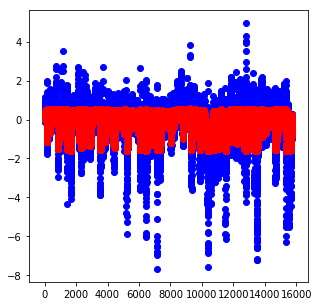

0.29548510909080505


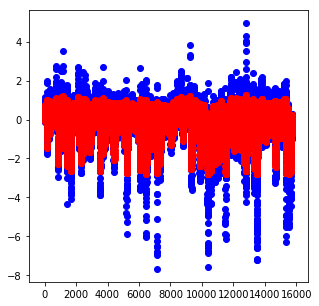

0.25106045603752136


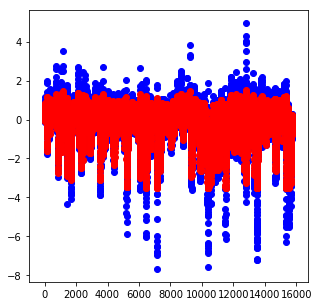

0.22925332188606262


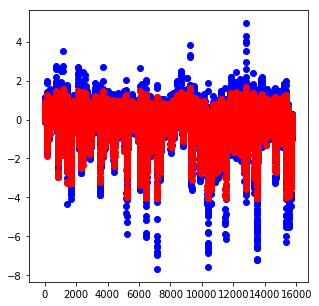

0.21460102498531342


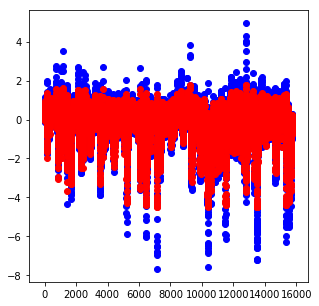

0.20472735166549683


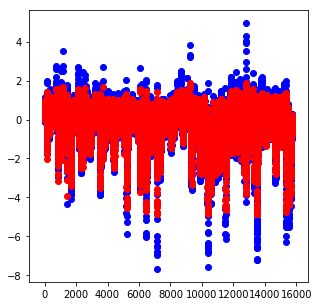

0.19830529391765594


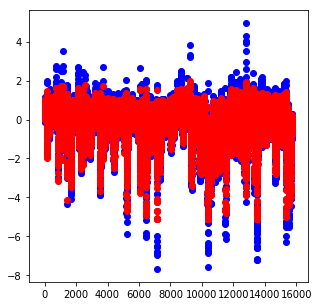

0.19405785202980042


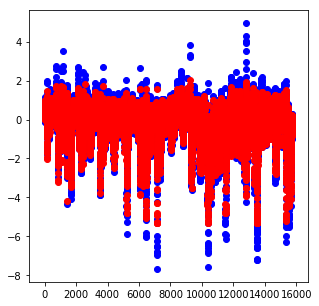

0.19209852814674377


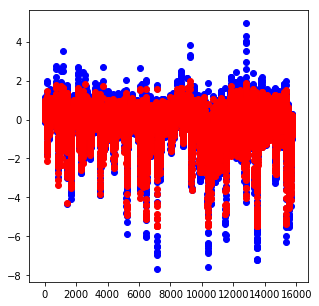

0.19071239233016968


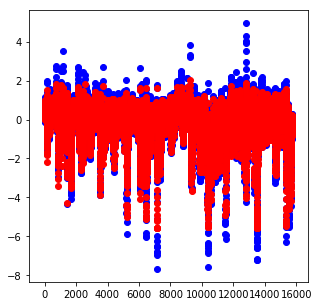

In [60]:

epochs = 1000
show_every = 100

model.train()
for e in range(epochs):
    model.zero_grad()
    prediction, hidden = model(x, hidden)
    loss = loss_fn(prediction, y)
    loss.backward()
    optimizer.step()
    if (e+1) % show_every == 0:
        print(loss.item())
        plt.figure(figsize=(5, 5))
        prediction = prediction.reshape(-1, 1)
        prediction = prediction.detach().numpy()
        plt.scatter(times, y.reshape(-1, 1), color='b')
        plt.scatter(times, prediction, color='r')
        plt.show()